# Load dataset


In [1]:
from pathlib import Path

base_path = Path(".").absolute().parents[0]

In [2]:
base_path

PosixPath('/home/20014946/Documents/Final_Project_PEM/Final_Project_PEM')

In [3]:
import sys

sys.path.insert(0, str(base_path / "src"))

In [4]:
str(base_path / "src")

'/home/20014946/Documents/Final_Project_PEM/Final_Project_PEM/src'

In [5]:
from google.cloud import bigquery

client = bigquery.Client(project="artefact-taxonomy")


from utils.text_utils import clean_html
from sklearn.model_selection import train_test_split

In [6]:
CUTOFF = 5

# Define the product_id and target / label
id_col = "adeo_product_id"
title_col = "title"
language_col = "lang"
description_raw = "description"
description_col = "description_clean"
label_raw_col = "mirakl_model_code"

In [7]:
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

In [8]:
df = pd.read_csv('../data/train.csv')

# Data Exploration

In [9]:
df.head()

,adeo_product_id,id,title,description,lang,attribute_code,attribute_label,attribute_type,is_multivalued,is_lov,attribute_value,lov_code,step_model_code,mirakl_model_code,data_source,description_clean
0,85266696,b'\xb1\xd4q\x83\x89\xcc\xb1\xec\xd6\x1a\xdc\xb...,Tapis tissé à la main move 4453 grau rouge - 1...,Facile d'entretien tapis de coton Ce coton ...,FR,2419,Style,CHAR,0,1,['Moderne'],64985,200853,200853|TAPIS_DE_SALON_CHAMBRE_SALLE_A_MANGER|T...,BOMP,Facile d'entretien tapis de coton Ce coton ...
1,85177753,"b'\xffT\x8d\xddQ\x9a,N^\x9d\xf3\x81\xb8\x8d2\x...",Fodera per cuscino Naturals Mermaids (50 x 50 cm),Se ti piace curare ogni singolo dettaglio dell...,IT,562,Forma,CHAR,0,1,['Quadrato'],900,202343,202343|HOUSSE_DE_COUSSIN|COUSSIN_ET_HOUSSE|R12...,BOMP,Se ti piace curare ogni singolo dettaglio dell...
2,84833908,b'\x99\xf8\xc3\xa2\xc8\x85vl\x06\x9e\x855\xee<...,Cojín Liso Gris oscuro (40 x 16 x 40 cm),<p>Si quieres darle a tu hogar un aire de orig...,ES,2419,Estilo,CHAR,0,1,['Diseño'],533,202345,202345|COUSSIN_DECORATIF|COUSSIN_ET_HOUSSE|R12...,BOMP,Si quieres darle a tu hogar un aire de origina...
3,84592677,"b'\\#hC\xc2\x9b""\x16\xc4\x8e\x10\x9b\x8a\xab\x...",PONTE RIALZATA 13 RUBINETTO LAVABO IN OTTONE N...,Questo rubinetto lavabo rialzato dal design el...,IT,1746,Colore,CHAR,1,1,['Nero opaco'],10106,201177,201177|MITIGEUR_DE_LAVABO|ROBINET_POUR_LAVABO_...,BOMP,Questo rubinetto lavabo rialzato dal design el...
4,84592677,b'\xd0\x83[\xabC\xda\xef\x1e\xd3\xd8\xa8\xa3\x...,ROBINET DE LAVABO SURÉLEVÉ SUR PLAGE 13 EN LAI...,Ce robinet de lavabo surélevé au design épuré ...,FR,1746,Couleur,CHAR,1,1,['Noir mat'],10106,201177,201177|MITIGEUR_DE_LAVABO|ROBINET_POUR_LAVABO_...,BOMP,Ce robinet de lavabo surélevé au design épuré ...


In [14]:
df['attribute_eng'] = 'None'

df['attribute_eng'].loc[df['attribute_code'] == 2419] = 'style'
df['attribute_eng'].loc[df['attribute_code'] == 1746] = 'color'
df['attribute_eng'].loc[df['attribute_code'] == 562] = 'shape'
df['attribute_eng'].loc[df['attribute_code'] == 15344] = 'battery_included'

Text(0.5, 1.0, 'Histogram of each attribute')

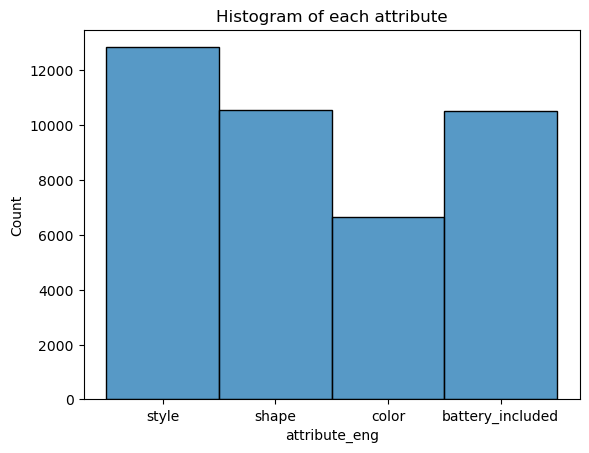

In [15]:
sns.histplot(data=df['attribute_eng'])

plt.title('Histogram of each attribute')

# Number of classes for each attribute

style
48
shape
54
color
77
battery_included
2


Text(0.5, 1.0, 'Number of class in each attribute')

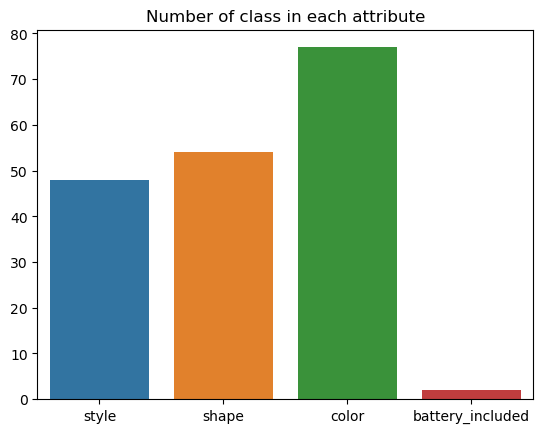

In [42]:
attribute_list = []
attribute_count = []
for attribute, attribute_eng in zip(df['attribute_code'].unique(), df['attribute_eng'].unique()):
    print (attribute_eng)
    print (len(df.loc[df['attribute_code']== int(attribute)].groupby('lov_code').count()))
    attribute_list.append(attribute_eng)
    attribute_count.append(len(df.loc[df['attribute_code']== int(attribute)].groupby('lov_code').count()))

sns.barplot(x=attribute_list, y=attribute_count)
plt.title('Number of class in each attribute')


In [43]:
df.head()

,adeo_product_id,id,title,description,lang,attribute_code,attribute_label,attribute_type,is_multivalued,is_lov,attribute_value,lov_code,step_model_code,mirakl_model_code,data_source,description_clean,attribute_eng
0,85266696,b'\xb1\xd4q\x83\x89\xcc\xb1\xec\xd6\x1a\xdc\xb...,Tapis tissé à la main move 4453 grau rouge - 1...,Facile d'entretien tapis de coton Ce coton ...,FR,2419,Style,CHAR,0,1,['Moderne'],64985,200853,200853|TAPIS_DE_SALON_CHAMBRE_SALLE_A_MANGER|T...,BOMP,Facile d'entretien tapis de coton Ce coton ...,style
1,85177753,"b'\xffT\x8d\xddQ\x9a,N^\x9d\xf3\x81\xb8\x8d2\x...",Fodera per cuscino Naturals Mermaids (50 x 50 cm),Se ti piace curare ogni singolo dettaglio dell...,IT,562,Forma,CHAR,0,1,['Quadrato'],900,202343,202343|HOUSSE_DE_COUSSIN|COUSSIN_ET_HOUSSE|R12...,BOMP,Se ti piace curare ogni singolo dettaglio dell...,shape
2,84833908,b'\x99\xf8\xc3\xa2\xc8\x85vl\x06\x9e\x855\xee<...,Cojín Liso Gris oscuro (40 x 16 x 40 cm),<p>Si quieres darle a tu hogar un aire de orig...,ES,2419,Estilo,CHAR,0,1,['Diseño'],533,202345,202345|COUSSIN_DECORATIF|COUSSIN_ET_HOUSSE|R12...,BOMP,Si quieres darle a tu hogar un aire de origina...,style
3,84592677,"b'\\#hC\xc2\x9b""\x16\xc4\x8e\x10\x9b\x8a\xab\x...",PONTE RIALZATA 13 RUBINETTO LAVABO IN OTTONE N...,Questo rubinetto lavabo rialzato dal design el...,IT,1746,Colore,CHAR,1,1,['Nero opaco'],10106,201177,201177|MITIGEUR_DE_LAVABO|ROBINET_POUR_LAVABO_...,BOMP,Questo rubinetto lavabo rialzato dal design el...,color
4,84592677,b'\xd0\x83[\xabC\xda\xef\x1e\xd3\xd8\xa8\xa3\x...,ROBINET DE LAVABO SURÉLEVÉ SUR PLAGE 13 EN LAI...,Ce robinet de lavabo surélevé au design épuré ...,FR,1746,Couleur,CHAR,1,1,['Noir mat'],10106,201177,201177|MITIGEUR_DE_LAVABO|ROBINET_POUR_LAVABO_...,BOMP,Ce robinet de lavabo surélevé au design épuré ...,color
